In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
 
from math import sqrt, exp
from scipy.stats import norm
from pylab import plot, show, grid, xlabel, ylabel

In [2]:
def plot_BTV_LTV(S, LTV):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('time in days')
    ax1.set_ylabel('BTC', color=color)
    ax1.plot(S, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:green'
    ax2.set_ylabel('LTV', color=color)  
    ax2.plot(LTV, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.axhline(y=1.5, color='r', linestyle='-')

    plt.title('Simulated BTC prices and LTV Ratios')
    fig.tight_layout() 
    #plt.savefig('plots\\sim_2.png', transparent=True)
    plt.show()

In [3]:
def sim_BTC_LTV(S0, LTV0, mu, sigma, n_paths, n_steps, seed=0):
    np.random.seed(seed)
    z = np.random.normal(0, 1, size = (n_paths, n_steps))
    
    n_steps = n_steps - 1 # Include S0
    
    # Simulate BTC paths
    S_multiplier = np.exp(sigma*np.sqrt(dt)*z + (mu - ((sigma**2)/2))*dt)
    S = [[S0]*n_paths]
    for i in range(n_steps):
        S.append(S[-1]*S_multiplier[:,i])
    S = np.array(S).T

    # Simulate LTV paths
    LTV_multiplier = np.exp(-sigma*np.sqrt(dt)*z + (-mu +sigma**2 - ((sigma**2)/2))*dt)
    LTV = [[LTV0]*n_paths]
    for i in range(n_steps):
        LTV.append(LTV[-1]*LTV_multiplier[:,i])
    LTV = np.array(LTV).T
    return {"BTC":S, "LTV":LTV, "Seed": seed, "mu": mu, "sigma": sigma, "z": z}

In [4]:
S0 = 9000
LTV0 = 0.7
sigma = 0.6
n_paths = 200000
n_steps = 100
dt = 1/365 # simulate daily 
z = np.random.normal(0, np.sqrt(dt), size = (n_paths, n_steps))
mu = 0.01/365 # Risk-free rate per day

In [5]:
sim_result  = sim_BTC_LTV(S0, LTV0, mu, sigma, n_paths, n_steps)

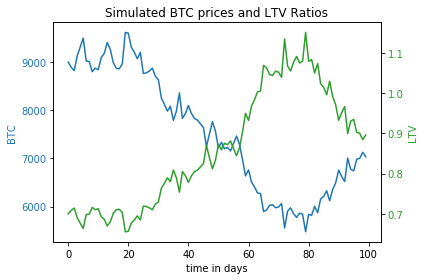

In [6]:
i = 2
plot_BTV_LTV(sim_result["BTC"][i,:], sim_result["LTV"][i,:])

In [7]:
sim_result['LTV'][0][0]

0.7

In [31]:
borrowed_amount_USD = 100
collateral_0_USD = borrowed_amount_USD/LTV0 # Initial value of BTC in USD 
collateral_0_BTC = collateral_0_USD/S0 # Number of BTC needed to be collateralised
r = 0.1 # SIMPLE INTEREST rate of the contract

def payoff(sim_result, thres, borrowed_amount_USD, r):
    passage = sim_result["LTV"]>= thres
    
    n_paths = sim_result['LTV'].shape[0]
    n_steps = sim_result['LTV'].shape[1]
    
    LTV0 = sim_result['LTV'][0][0]
    S0 = sim_result['BTC'][0][0]
    
    collateral_0_USD = borrowed_amount_USD/LTV0 # Initial value of BTC in USD 
    collateral_0_BTC = collateral_0_USD/S0 # Number of BTC needed to be collateralised

    
    first_passage = np.zeros((n_paths), dtype=np.int) # Record the index of each path when the path first hit K
    
    for i in range(n_paths):
        try: 
            first_passage[i] = int(np.where(passage[i,:] >= thres)[0][0])
        except:
            pass

    # To see how many paths hitted K
    liquidised_paths = np.sum(passage , axis=1) != 0
    prob_hit_K = np.mean(liquidised_paths) # number of paths hit K once divided total number of paths
    
    payoff = np.zeros(n_paths)
    interest = r*borrowed_amount_USD # 10 USD interest on top of borrowed amount to be returned
    interest_0 = interest/((1+mu)**n_steps) # discounted interest

    for i in range(n_paths):
        if liquidised_paths[i]:
            # The value of BTC at first passage
            collateral_tau = collateral_0_BTC*sim_result["BTC"][i, int(first_passage[i])]
            payoff[i] = collateral_tau/((1+mu)**first_passage[i])
        else:
            payoff[i] = borrowed_amount_USD + interest_0
            
    return {"payoff":payoff, 'first_passage':first_passage, 
            "liquidised_paths": liquidised_paths, "thres":thres,
            "borrowed_amount_USD":borrowed_amount_USD, "r": r}


In [9]:
Ks = np.linspace(0.6, 1.0, num=100) # check for different threshold
Ps = np.zeros(100) # contract value at t_0

for i, K in enumerate(Ks):
    results = payoff(sim_result, K, borrowed_amount_USD, r)
    Ps[i] = np.mean(results['payoff'])
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


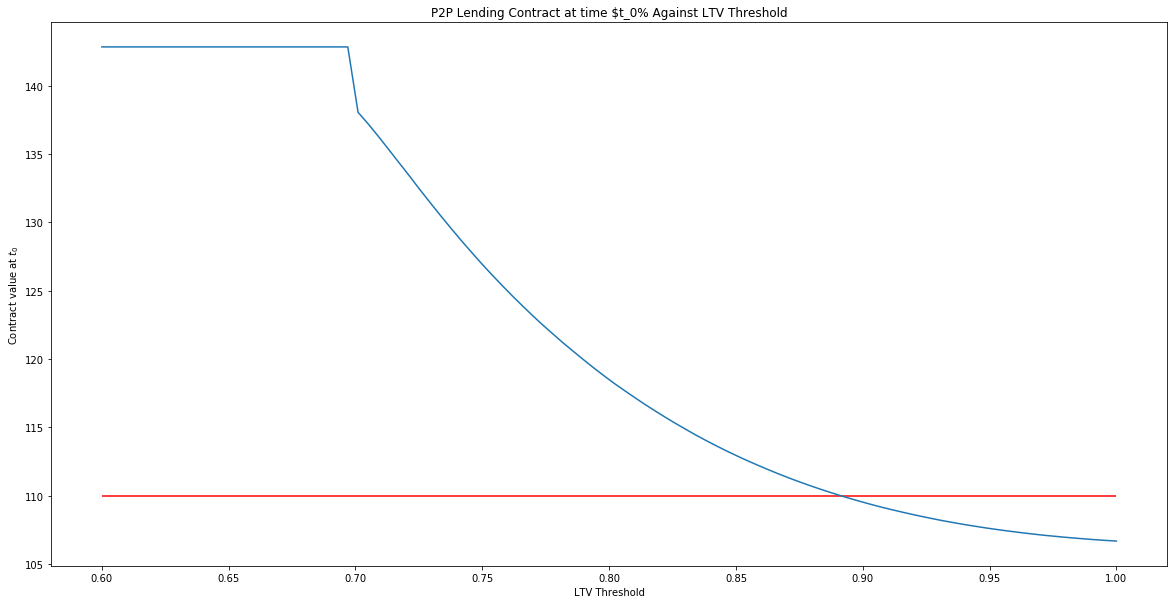

In [41]:
plt.figure(figsize=(20,10))
plt.title("P2P Lending Contract at time $t_0% Against LTV Threshold")
plt.plot(Ks, Ps)
plt.xlabel('LTV Threshold')  
plt.ylabel('Contract value at $t_0$')  


interest = r*borrowed_amount_USD # 10 USD interest on top of borrowed amount to be returned
interest_0 = interest/((1+mu)**n_steps) # discounted interest


i = np.argmin(np.abs(Ps - (borrowed_amount_USD + interest_0)))

plt.hlines((borrowed_amount_USD + interest_0), xmin=0.6, xmax=1, color='red')

In [32]:
interest = r*borrowed_amount_USD # 10 USD interest on top of borrowed amount to be returned
interest_0 = interest/((1+mu)**n_steps) # discounted interest

i = np.argmin(np.abs(Ps - (borrowed_amount_USD + interest_0)))
Ks[i]

0.8909090909090909

In [33]:
results = payoff(sim_result, thres, borrowed_amount_USD, r)

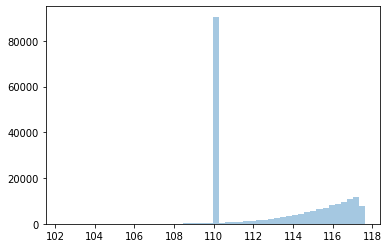

In [35]:
sns.distplot(results["payoff"],kde=False)

In [36]:
np.mean(results["payoff"])

112.94313043004087

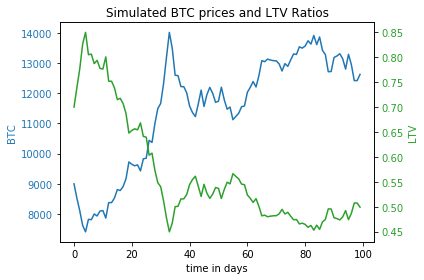

Collateral is liquidised at 7411.651593872595 USD
Collateral value at tau 117.6452633948031 USD
tau= 4


In [38]:
i = np.argmax(results["payoff"])
plot_BTV_LTV(sim_result['BTC'][i,:], sim_result['LTV'][i,:])
print("Collateral is liquidised at",
      sim_result['BTC'][i,first_passage[i]],"USD")
print("Collateral value at tau",
      collateral_0_BTC*sim_result['BTC'][i,first_passage[i]],"USD")
print("tau=", first_passage[i])